# Multi-View-Majority-Vote-Learning-Algorithms-Direct-Minimization-of-PAC-Bayesian-Bounds

This Notebook contains everything necessary to reproduce the experiments in our paper:  

*Multi-View Majority Vote Learning Algorithms: Direct Minimization of PAC-Bayesian Bounds*

## Imports

In [9]:
# %pip install -r requirements.txt

In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from termcolor import colored
from datetime import datetime

# Scikit-learn
from sklearn import preprocessing
from sklearn.utils import check_random_state

# torch
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


from mvpb import MultiViewMajorityVoteLearner, MajorityVoteLearner
from mvpb.util import uniform_distribution


# Import data
from data import (SampleData,
                           Nhanes,
                           MultipleFeatures,
                           MNIST_MV_Datasets,
                           Fash_MNIST_MV_Datasets,
                           EMNIST_Letters_MV_Datasets,
                           Mushrooms,
                           PTB_XL_plus,
                           Nutrimouse,
                           ReutersEN,
                           IS,
                           CorelImageFeatures,
                           NUS_WIDE_OBJECT,
                           ALOI,
                           train_test_split,
                           train_test_merge,
                           s1_s2_split,
                           multiclass_to_binary,
                           balance_dataset,
                           other_binary_options,
                           poison_dataset)

## Load and prepare the multiview datasets

In [2]:
dataset = MultipleFeatures(size="large")
X_train, y_train, X_test, y_test = dataset.get_data()
if isinstance(dataset, PTB_XL_plus):
    real_classes = dataset.get_real_classes(np.unique(y_train))

Xs_train = []
Xs_test = []
for xtr, xts in zip(X_train, X_test):
    scaler = preprocessing.MinMaxScaler().fit(xtr)
    Xs_train.append(scaler.transform(xtr))
    Xs_test.append(scaler.transform(xts))

X_train_concat = [np.concatenate(Xs_train, axis=1)]
X_test_concat = [np.concatenate(Xs_test, axis=1)]

np.unique(y_train), np.unique(y_test)

KeyboardInterrupt: 

In [ ]:
X_train[1].shape, y_train.shape, X_test[1].shape, y_test.shape

((60000, 200), (60000,), (10000, 200), (10000,))

In [ ]:
RUNS = range(10)

OPTIMIZE_LAMBDA_GAMMA = True
# ALPHA = [1, 0.5, 1.1, 2]
ALPHA = [0.5]
MAX_ITER = 1000

stump_config = {
    "name": "stump",
    "n_estimators": 100,
    "max_depth": 1,
    "max_features": 0.5,
}
weak_learners_config = {
    "name": "weak_learner",
    "n_estimators": 100,
    "max_depth": 3,
    "max_features": 0.5,
}
strong_learners_config = {
    "name": "strong_learner",
    "n_estimators": 100,
    "max_depth": 6,
    "max_features": 0.8,
}

# CFG = [stump_config, weak_learners_config, strong_learners_config]
CFG = [weak_learners_config]

EPOCHS = 15

TO_BINARY  = "ovo" # One of ["ovr", "ovo", "other",  None]
label_1 = 4
# if isinstance(dataset, PTB_XL_plus):
#     label_1 = np.unique(y_test)[np.where(real_classes == "['NORM']")[0][0]]
label_2 = 9

POISON = False

USE_UNLABELED = True
# s_labeled_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5] if USE_UNLABELED else [1]
s_labeled_sizes = [0.2] if USE_UNLABELED else [0.1]

UNIFORM_WEIGHTING = False
BOUNDS = ['PBkl', 'PBkl_inv', 'TND_DIS', 'TND_DIS_inv', 'TND', 'TND_inv', 'DIS', 'DIS_inv', 'Cbound', 'C_TND']
# BOUNDS = ['TND_DIS', 'TND_DIS_inv']

m = y_train.size #350
test_size = 1 - (m  / (y_test.size+y_train.size))
experiments = {}
for s_labeled_size in s_labeled_sizes:
    experiments[s_labeled_size] = {}
    for alpha in ALPHA:
        experiments[s_labeled_size][alpha] = {}
        for cfg in CFG:
            experiments[s_labeled_size][alpha][cfg["name"]] = []

In [ ]:
experiments

{0.2: {0.5: {'weak_learner': []}}}

In [ ]:
# if POISON:
#     Xs_train, y_train = poison_dataset(Xs_train, y_train, poison_label=label_1, target_label=label_2, target_view=3, num_samples=4000)

In [ ]:
# Transform to binary OVR (One Vs Rest) or OVO (One Vs One) if needed
if TO_BINARY == "ovr":
    Xs_train, y_train, Xs_test, y_test = multiclass_to_binary(Xs_train, y_train, Xs_test, y_test, type=TO_BINARY, label_1=label_1)
elif TO_BINARY == "ovo":
    Xs_train, y_train, Xs_test, y_test = multiclass_to_binary(Xs_train, y_train, Xs_test, y_test, type=TO_BINARY, label_1=label_1, label_2=label_2)
elif TO_BINARY == "other":
    y_train, y_test = other_binary_options(dataset, y_train, y_test)
else:
    print(colored(f"WARNING: TO_BINARY={TO_BINARY}, continuing", 'yellow'))

In [ ]:
before_merge = (Xs_train, y_train, Xs_test, y_test)
Xs, y = train_test_merge(Xs_train, y_train, Xs_test, y_test)
# os.makedirs("results", exist_ok=True)
    

def metric_dict(mv_metric, v_metrics):
    metric_dict = {f"View{i+1}": v_metrics[i] for i in range(len(v_metrics)-1)}
    metric_dict.update({"Concatenated": v_metrics[-1]})
    metric_dict.update({"Multiview": mv_metric})
    return metric_dict

# iterate over the labeled data sizes #
for i, s1_size in enumerate(s_labeled_sizes):
    print(colored(f"############ Using {s1_size*100}% labeled data ############", 'black', on_color='on_blue'))
    s_labeled_dir = 'results'+f"/s_labeled-{int(s1_size*100)}"
    # os.makedirs(s_labeled_dir, exist_ok=True)
### iterate over the alpha values ###
    
    for j, alpha in enumerate(ALPHA):
        print(colored(f"\t############ Using {alpha=} ############", 'black', on_color='on_blue'))
        alpha_dir = s_labeled_dir+ f"/alpha-{alpha}"
        # os.makedirs(alpha_dir, exist_ok=True)
        
#### iterate over the configurations ####
        for k, config in enumerate(CFG):
            print(colored(f"\t\t############ Using {config['name']} ############", 'black', on_color='on_blue'))
            for run in RUNS:
                print(colored(f"\n----------------Run {run+1}---------------", 'blue'))

                # Shuffle and split the dataset into training and testing
                # if not dataset.split:
                Xs_train, y_train, Xs_test, y_test = train_test_split(Xs, y, test_size=test_size, random_state=run*(i+1)*(j+1)*(k+1))
                # else:
                # Xs_train, y_train, Xs_test, y_test = before_merge

                # Split the dataset into labeled and unlabeled
                Xs_train, y_train, UlX, _ = s1_s2_split(Xs_train, y_train, s1_size=s1_size, random_state=run*(i+1)*(j+1)*(k+1))
                X_train_concat = np.concatenate(Xs_train, axis=1)
                X_test_concat = np.concatenate(Xs_test, axis=1)
                    
                # instantiate multiview dNDF classifier
                dNDF_mv = MultiViewMajorityVoteLearner(nb_estimators=config["n_estimators"],
                                                        nb_views=len(Xs_train),
                                                        depth =config["max_depth"],
                                                        used_feature_rate=config["max_features"],
                                                        random_state=run,
                                                        epochs=EPOCHS,
                                                        use_dndf=False)
                
                # instantiate dNDF classifier for separate views and concatenated view
                # dNDF_per_view = []
                # for v in range(len(Xs_train)+1):
                #     dNDF_per_view.append(MajorityVoteLearner(nb_estimators=config["n_estimators"],
                #                                             depth =config["max_depth"],
                #                                             used_feature_rate=config["max_features"],
                #                                             random_state=run,
                #                                             epochs=EPOCHS,
                #                                             use_dndf=False))
                
                print("Training multiview classifier-------------------------------")
                dNDF_mv = dNDF_mv.fit(Xs_train, y_train)
                
                # print("Training separate views classifiers-------------------------------")
                # for v in range(len(Xs_train)):
                #     dNDF_per_view[v] = dNDF_per_view[v].fit(Xs_train[v], y_train)

                # print("Training concatenated view classifier-------------------------------")
                # dNDF_per_view[-1] = dNDF_per_view[-1].fit(X_train_concat, y_train)
                
                
                # Optimize the posterior distributions for the each bound
                for bound in BOUNDS:
                    # Clear the posteriors (reset to uniform distribution)
                    dNDF_mv.clear_posteriors()
                    # for v in range(len(Xs_train)+1):
                    #     dNDF_per_view[v].clear_posteriors()
                    
                    # use the unlabeled data for DIS
                    unlabeled_data, c_unlabeled_data = None, None
                    if USE_UNLABELED and bound in ['DIS', 'DIS_inv', 'TND_DIS', 'TND_DIS_inv',]:
                        unlabeled_data = UlX
                        c_unlabeled_data = np.concatenate(UlX, axis=1)
                    
                    if UNIFORM_WEIGHTING:
                        posterior_Qv = dNDF_mv.posterior_Qv
                        posterior_rho = dNDF_mv.posterior_rho
                        # posterior_Qs = [dNDF_per_view[v].posterior_Q.tolist() for v in range(len(dNDF_per_view))]
                    else:
                        _, gibbs_risk, _ = dNDF_mv.mv_risk((Xs_train, y_train), incl_oob=False)
                        print(f"### Multiview classifier gibbs risk before Optim: {gibbs_risk}")
                        print(colored(f"Optimizing {bound} for multiview classifier-------------------------------", 'green'))
                        prev_time = datetime.now()
                        posterior_Qv , posterior_rho = dNDF_mv.optimize_rho(bound,
                                                                            labeled_data=(Xs_train, y_train),
                                                                            unlabeled_data=unlabeled_data,
                                                                            incl_oob=False,
                                                                            max_iter=MAX_ITER,
                                                                            optimise_lambda_gamma=OPTIMIZE_LAMBDA_GAMMA,
                                                                            alpha=alpha)
                        print(colored(f"Optimization took {datetime.now() - prev_time} -------------------------------", 'yellow'))
                        
                        # print(colored(f"Optimizing {bound} for separate views classifiers-------------------------------", 'green'))
                        # posterior_Qs = []
                        # for v in range(len(Xs_train)):
                        #     posterior_Q = dNDF_per_view[v].optimize_Q(bound,
                        #                                                     labeled_data=(Xs_train[v], y_train),
                        #                                                     unlabeled_data=unlabeled_data[v] if unlabeled_data else None,
                        #                                                     incl_oob=False,
                        #                                                     max_iter=MAX_ITER,
                        #                                                     optimise_lambda_gamma=OPTIMIZE_LAMBDA_GAMMA,
                        #                                                     alpha=1)
                        #     posterior_Qs.append(posterior_Q.tolist())
                        # print(colored(f"Optimizing {bound} for concatenated classifier-------------------------------", 'green'))
                        # posterior_Q_concat = dNDF_per_view[-1].optimize_Q(bound,
                        #                                                     labeled_data=(X_train_concat, y_train),
                        #                                                     unlabeled_data=c_unlabeled_data,
                        #                                                     incl_oob=False,
                        #                                                     max_iter=MAX_ITER,
                        #                                                     optimise_lambda_gamma=OPTIMIZE_LAMBDA_GAMMA,
                        #                                                     alpha=1)
                        # posterior_Qs.append(posterior_Q_concat.tolist())
                        
                        _, gibbs_riska, _ = dNDF_mv.mv_risk((Xs_train, y_train), incl_oob=False)
                        print(f"### Multiview classifier gibbs risk after Optim: {gibbs_riska}")
                        # Compute the bound for the multiview classifier
                        print(colored(f"Optimization is done! -------------------------------", 'green'))
                    
                    print(colored(f"Computing the bound values ans risks -------------------------------", 'green'))
                    mv_bound, mv_grisk, mv_eS, mv_dS, mv_klqp, klrpi, ng, _, nd = dNDF_mv.bound(
                                        bound=bound,
                                        labeled_data=(Xs_train, y_train),
                                        unlabeled_data=unlabeled_data,
                                        incl_oob=False,
                                        alpha=alpha)
                    # Compute the risk of the multiview classifier
                    P, mv_risk = dNDF_mv.predict_MV(Xs_test, y_test)
                    
                    gibbs_risks_mat, ns_views = dNDF_mv.risks((Xs_test, y_test), incl_oob=False)
                    # print(f"{risks_views=}, {ns_views=}")
                    grisks_views = np.divide(gibbs_risks_mat, ns_views, where=ns_views!=0)
                    # print(f"After {grisks_views=}")
                    emp_rv = []
                    for q, rv in zip(dNDF_mv.posterior_Qv, grisks_views):
                        emp_rv.append(np.average(rv, weights=q.cpu().detach().numpy(), axis=0))
                    
                    grisks_views_list = [grisks_views[i].tolist() for i in range(len(grisks_views))]
                    
                        
                        
                    
                    
                    # Compute the bounds and risks for the separate views classifiers
                    # v_bounds = []
                    # v_grisks = []
                    # v_eSs = []
                    # v_dSs = []
                    # v_klqps = []
                    # for v in range(len(Xs_test)+1):
                    #     if v == len(Xs_test):
                    #         # Compute the bound for the concatenated view
                    #         concat_bound, grisk, eS, dS, klqp, _, _, _ = dNDF_per_view[v].bound(
                    #                     bound=bound,
                    #                     labeled_data=(X_train_concat, y_train),
                    #                     unlabeled_data=c_unlabeled_data,
                    #                     incl_oob=False,
                    #                     alpha=1)
                    #         v_bounds.append(concat_bound)
                    #     else:
                    #         # Compute the bound for the separate views
                    #         v_bound, grisk, eS, dS, klqp, _, _, _ = dNDF_per_view[v].bound(
                    #                         bound=bound,
                    #                         labeled_data=(Xs_train[v], y_train),
                    #                         unlabeled_data=unlabeled_data[v] if unlabeled_data else None,
                    #                         incl_oob=False,
                    #                         alpha=1)
                    #         v_bounds.append(v_bound)
                    #     v_grisks.append(grisk)
                    #     v_eSs.append(eS)
                    #     v_dSs.append(dS)
                    #     v_klqps.append(klqp)
                    
                    # v_risks = [dNDF_per_view[v].predict(Xs_test[v], y_test)[1] for v in range(len(Xs_test))]
                    # v_risks.append(dNDF_per_view[-1].predict(X_test_concat, y_test)[1])
                    # print(f"{dNDF_mv.posterior_Qv=} {dNDF_mv.posterior_rho=}")
                    

                    # Save the results
                    print(colored(f"Entering save and stats zone-------------------------------", 'green'))
                    # views_risks = metric_dict(mv_risk, v_risks)
                    # views_gibbs_risks = metric_dict(mv_grisk, v_grisks)
                    # views_eSs = metric_dict(mv_eS, v_eSs)
                    # views_dSs = metric_dict(mv_dS, v_dSs)
                    # views_bounds = metric_dict(mv_bound, v_bounds)
                    # views_klqps = metric_dict(mv_klqp, v_klqps)
                    views_kl_rhopi = metric_dict(klrpi, [np.nan for _ in range(len(Xs_test)+1)])
                    
                    list_posterior_Qv = [q.tolist() for q in posterior_Qv]
                    rounded_posterior_Qv = [[float("{:.9f}".format(q)) for q in Q] for Q in list_posterior_Qv]
                    rounded_posterior_rho = [float("{:.9f}".format(rho)) for rho in posterior_rho.tolist()]
                    # rounded_posterior_Qs = [["{:.9f}".format(q) for q in Q] for Q in posterior_Qs]
                    # views_posterior_Qs = metric_dict(rounded_posterior_Qv, rounded_posterior_Qs)
                    # views_posterior_rho = metric_dict(rounded_posterior_rho, [np.nan for _ in range(len(Xs_test)+1)])
                    
                    
                    # assert len(views_risks) == len(views_bounds)
                    # assert len(views_risks) == len(views_gibbs_risks) and len(views_risks) == len(views_eSs)
                    # assert len(views_dSs) == len(views_eSs)
                    
                    exp = {"Run": run+1, 
                        "Bound_name": bound,
                        "Risk": float("{:.3f}".format(mv_risk)),
                        "Bound": float("{:.3f}".format(mv_bound)),
                        "Gibbs_Risks_estimators": grisks_views_list,
                        "Gibbs_Risks_views": emp_rv,
                        "Join_Error": float("{:.3f}".format(mv_eS)),
                        "Disagreement": float("{:.3f}".format(mv_dS)),
                        "KL_QP": float("{:.3f}".format(mv_klqp)),
                        "KL_RhoPi": float("{:.3f}".format(klrpi)),
                        "n_labeled": ng,
                        "n_all": nd,
                        "Posterior_Qv": rounded_posterior_Qv,
                        "Posterior_rho": rounded_posterior_rho}
                    experiments[s1_size][alpha][config["name"]].append(exp)
                    # TODO: add the posterior_Qv and posterior_rho to the experiment
                # del dNDF_mv, dNDF_per_view
                
            # cfg_dir = alpha_dir + "/" + config["name"]
            # os.makedirs(cfg_dir, exist_ok=True)
            experiment_df = pd.DataFrame(experiments[s1_size][alpha][config["name"]])
            # example: results/s_labeled-5/alpha-1/stump/MNIST_4vs9_20runs.csv
            file_name = f"results/{dataset._name}_{label_1}vs{label_2}_{len(RUNS)}runs_{int(s1_size*100)}labeled_{alpha}alpha_{config['name']}_results.csv"
            experiment_df.to_csv(file_name, sep=";", index=False)

############ Using 20.0% labeled data ############
	############ Using alpha=0.5 ############
		############ Using weak_learner ############

----------------Run 1---------------
Training multiview classifier-------------------------------
### Multiview classifier gibbs risk before Optim: 0.2974400225797347
Optimizing PBkl for multiview classifier-------------------------------
	 Convergence reached after 103 iterations
Optimization took 0:00:05.016355 -------------------------------
### Multiview classifier gibbs risk after Optim: 0.15657252829909468
Optimization is done! -------------------------------
Computing the bound values ans risks -------------------------------
right_hand_side=0.0029141202039314348, empirical_gibbs_risk=0.15657252829909468
Entering save and stats zone-------------------------------
### Multiview classifier gibbs risk before Optim: 0.2974400225797347
Optimizing PBkl_inv for multiview classifier-------------------------------
	 Convergence reached after 151 it

KeyboardInterrupt: 

In [ ]:
os.makedirs("results-dup", exist_ok=True)

for s_labeled_size, size_exp in experiments.items():
    s_labeled_dir = 'results-dup'+f"/s_labeled-{int(s_labeled_size*100)}"
    os.makedirs(s_labeled_dir, exist_ok=True)
    for alpha, alpha_exp in size_exp.items():
        alpha_dir = s_labeled_dir+ f"/alpha-{alpha}"
        os.makedirs(alpha_dir, exist_ok=True)
        for cfg, cfg_exp in alpha_exp.items():
            if cfg_exp == []:
                continue
            cfg_dir = alpha_dir + "/" + cfg
            os.makedirs(cfg_dir, exist_ok=True)
            experiment_df = pd.DataFrame(cfg_exp)
            # example: results-dup/s_labeled-5/alpha-1/stump/MNIST_4vs9_20runs.csv
            file_name = f"{cfg_dir}/{dataset._name}_{label_1}vs{label_2}_{len(RUNS)}runs.csv"
            experiment_df.to_csv(file_name, sep=" ", index=False)


In [ ]:
df = pd.DataFrame(experiments[0.2][0.5]["weak_learner"])
df["Risk"] = df["Risk"].astype(float)
df["Bound"] = df["Bound"].astype(float)
# df['Bound'] = df['Bound'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x)
# df['Risk'] = df['Risk'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x)
df.head(20)

In [ ]:
df[df["Risk"] > df["Bound"]]

In [ ]:
# agg_df = df.groupby(["Bound_name", "View"]).mean()
# agg_df

<Axes: >

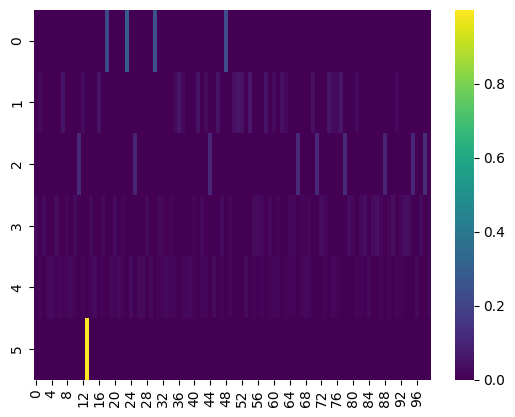

In [ ]:
posterior_rho
sns.heatmap(posterior_Qv, fmt=".2f", cmap='viridis')

In [ ]:
def plot_results(experiments, m, runs=len(RUNS), bounds=BOUNDS):
    sns.set_style(style="ticks")
    bounds_palette = sns.mpl_palette("viridis", n_colors=len(bounds))
    risk_palette = sns.color_palette("flare", n_colors=len(bounds))
    risk_palette.reverse()
    
    ax = sns.barplot(experiments, x='View', hue='Bound_name', y='Bound', errorbar="sd", width=0.8, hatch='.', palette=bounds_palette)
    ax = sns.barplot(experiments, x='View', hue='Bound_name', y='Risk', errorbar="sd", width=0.8, hatch='\\', palette=risk_palette)

    plt.title(f'Test error rates and multiview PAC-Bayesian bound values, {m=},\naveraged over {runs} runs')
    plt.xlabel('Views')
    plt.ylabel('Means')
    
    handles, labels = ax.get_legend_handles_labels()
    labels = [labels[i]+" bound" if i < len(labels)/2 else labels[i]+" Gibbs risk" for i in range(len(labels))]

    # Creating a unified legend for both plots
    plt.legend(handles, labels, title="Bounds and risks", loc='upper right', fontsize='medium')
    plt.tight_layout() 
    plt.gcf().set_size_inches(24, 12)
    plt.show()

In [ ]:
plot_results(df, len(Xs_train[0]))